# epymorph: migrating from v0.8 to v0.9

In the spirit of the last "rosetta stone" notebooks (dated 2024-07-12)...

Running simulation (BasicSimulator):
• 2015-01-01 to 2016-08-22 (600 days)
• 1 geo nodes
  |####################| 100%                     
Runtime: 0.165s


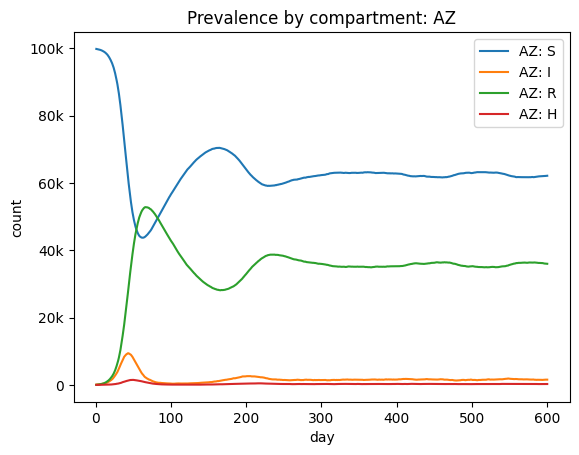

In [1]:
# Example 1: basic simulation

from epymorph.kit import *

rume = SingleStrataRume.build(
    ipm=ipm.Sirh(),
    mm=mm.No(),
    init=init.SingleLocation(location=0, seed_size=100),
    scope=CustomScope(["AZ"]),
    time_frame=TimeFrame.of("2015-01-01", 600),
    params={
        "beta": 0.4,
        "gamma": 1 / 4,
        "xi": 1 / 90,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7,
        "population": [100_000],
    },
)

sim = BasicSimulator(rume)
with sim_messaging():
    output = sim.run(
        # params={'beta': 0.9},
        rng_factory=default_rng(42),
    )
    output.plot.line(
        geo=rume.scope.select.all(),
        time=rume.time_frame.select.all(),
        quantity=rume.ipm.select.compartments(),
        title="Prevalence by compartment: AZ",
    )

Loading epymorph.adrio.us_tiger.PostalCode:
  |####################| 100%  (0.153s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-30 (150 days)
• 6 geo nodes
  |####################| 100%                     
Runtime: 0.297s


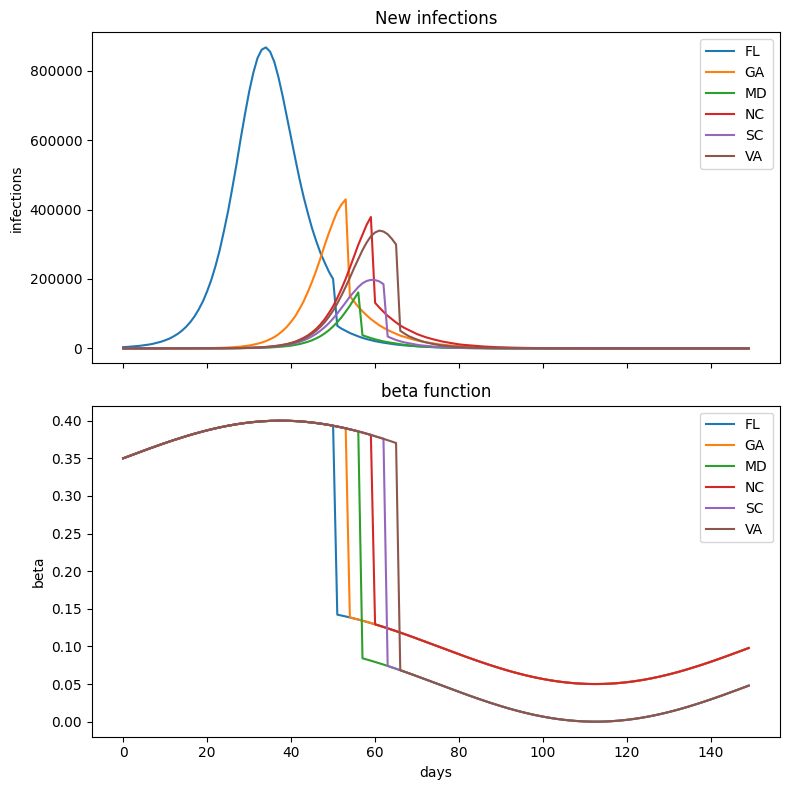

In [2]:
# Example 2: custom parameter functions

from math import pi, sin

import matplotlib.pyplot as plt
import numpy as np

from epymorph.kit import *
from epymorph.data import pei
from epymorph.adrio import us_tiger

POPULATION = AttributeDef("population", int, Shapes.N)


class Beta(ParamFunctionTimeAndNode):
    requirements = [POPULATION]

    def evaluate1(self, day: int, node_index: int) -> float:
        x = 0.35 + 0.05 * sin(2 * pi * (day / self.time_frame.days))
        cutoff = 50 + (node_index * 3)
        if day > cutoff:
            pop = self.data(POPULATION)[node_index]
            cut = 0.3 if pop < 9_000_000 else 0.25
            x -= cut
        return x


rume = SingleStrataRume.build(
    scope=pei.pei_scope,
    ipm=ipm.Sirs(),
    mm=mm.Pei(),
    init=init.SingleLocation(location=0, seed_size=10_000),
    time_frame=TimeFrame.of("2015-01-01", 150),
    params={
        "beta": Beta(),
        "gamma": 1 / 6,
        "xi": 1 / 90,
        "theta": 0.1,
        "move_control": 0.9,
        "population": pei.pei_population,
        "commuters": pei.pei_commuters,
        "meta::geo::label": us_tiger.PostalCode(),
    },
)

sim = BasicSimulator(rume)
with sim_messaging():
    out = sim.run()

# For the sake of graphing beta, I need to evaluate it.
beta_values = (
    Beta()
    .with_context(
        scope=rume.scope,
        time_frame=rume.time_frame,
        params={"population": pei.pei_population},
    )
    .evaluate()
)


### GRAPHS ###
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 8))
out.plot.line_plt(
    ax=ax1,
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all().group("day").agg(),
    quantity=rume.ipm.select.events("S->I"),
    time_format="day",
    label_format="{n}",
)
ax1.set(title="New infections", ylabel="infections")
ax1.legend()

ax2.plot(beta_values, label=out.rume.scope.labels)
ax2.set(title="beta function", ylabel="beta", xlabel="days")
ax2.legend()

fig.tight_layout()
plt.show()

Loading epymorph.adrio.us_tiger.PostalCode:
  |####################| 100%  (0.097s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-02-19 (50 days)
• 6 geo nodes
  |####################| 100%                    
Runtime: 0.041s


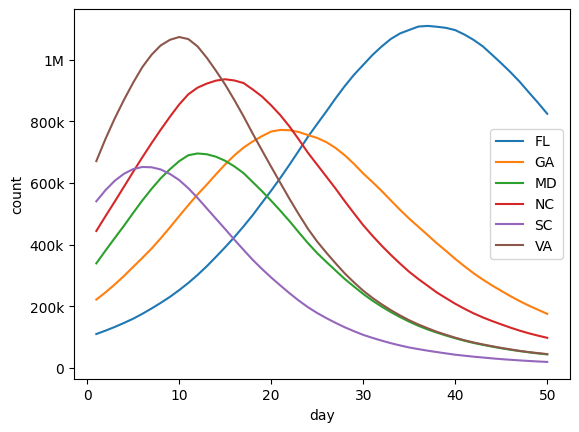

In [3]:
# Example 3: custom initialization

import numpy as np

from epymorph.kit import *
from epymorph.adrio import us_tiger
from epymorph.data import pei

POPULATION = AttributeDef("population", int, Shapes.N)


class MyInitializer(init.Initializer):
    requirements = [POPULATION]

    infected_multiplier: int

    def __init__(self, infected_multiplier: int = 100_000):
        self.infected_multiplier = infected_multiplier

    def evaluate(self):
        N = self.scope.nodes
        C = self.ipm.num_compartments
        initial = np.zeros(shape=(N, C), dtype=SimDType)
        initial[:, 0] = self.data(POPULATION)
        for n in range(N):
            initial[n, 0] -= self.infected_multiplier * (n + 1)
            initial[n, 1] += self.infected_multiplier * (n + 1)
        return initial


rume = SingleStrataRume.build(
    scope=pei.pei_scope,
    ipm=ipm.Pei(),
    mm=mm.No(),
    init=MyInitializer(),
    # init=MyInitializer(10000),
    time_frame=TimeFrame.of("2015-01-01", duration_days=50),
    params={
        "infection_duration": 4,
        "immunity_duration": 90,
        "population": pei.pei_population,
        "humidity": pei.pei_humidity,
        "meta::geo::label": us_tiger.PostalCode(),
    },
)

sim = BasicSimulator(rume)
with sim_messaging():
    out = sim.run()

out.plot.line(
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all(),
    quantity=rume.ipm.select.compartments("I"),
    label_format="{n}",
)

In [4]:
# Example 4: construct a multistrata RUME

import matplotlib.pyplot as plt
import numpy as np
from sympy import Max

from epymorph.kit import *
from epymorph.adrio import acs5, us_tiger

# Select 21 census tracts out of Maricopa County, AZ
maricopa_tracts = TractScope.in_counties(["04013"], year=2020)

subset_tracts = maricopa_tracts.node_ids[::33][0:21]

scope = TractScope.in_tracts(subset_tracts.tolist(), year=2020)

print(f"The census tracts we'll model:\n{scope.node_ids}")


class MyRume(MultistrataRumeBuilder):
    strata = [
        Gpm(
            name="age_00-19",
            ipm=ipm.Sirs(),
            mm=mm.Centroids(),
            init=init.NoInfection(),
        ),
        Gpm(
            name="age_20-59",
            ipm=ipm.Sirs(),
            mm=mm.Centroids(),
            init=init.SingleLocation(location=0, seed_size=100),
        ),
        Gpm(
            name="age_60-79",
            ipm=ipm.Sirs(),
            mm=mm.No(),
            init=init.NoInfection(),
        ),
    ]

    meta_requirements = [
        AttributeDef("beta_12", float, Shapes.TxN),
        AttributeDef("beta_13", float, Shapes.TxN),
        AttributeDef("beta_21", float, Shapes.TxN),
        AttributeDef("beta_23", float, Shapes.TxN),
        AttributeDef("beta_31", float, Shapes.TxN),
        AttributeDef("beta_32", float, Shapes.TxN),
    ]

    def meta_edges(self, symbols: MultistrataModelSymbols) -> list[TransitionDef]:
        # extract compartment symbols by strata
        S_1, I_1, R_1 = symbols.strata_compartments("age_00-19")
        S_2, I_2, R_2 = symbols.strata_compartments("age_20-59")
        S_3, I_3, R_3 = symbols.strata_compartments("age_60-79")

        # extract compartment totals by strata
        N_1 = Max(1, S_1 + I_1 + R_1)
        N_2 = Max(1, S_2 + I_2 + R_2)
        N_3 = Max(1, S_3 + I_3 + R_3)

        # extract meta attributes
        beta_12, beta_13, beta_21, beta_23, beta_31, beta_32 = (
            symbols.all_meta_requirements
        )

        return [
            edge(S_1, I_1, rate=S_1 * beta_12 * I_2 / N_2),  # 2 infects 1
            edge(S_1, I_1, rate=S_1 * beta_13 * I_3 / N_3),  # 3 infects 1
            edge(S_2, I_2, rate=S_2 * beta_21 * I_1 / N_1),  # 1 infects 2
            edge(S_2, I_2, rate=S_2 * beta_23 * I_3 / N_3),  # 3 infects 2
            edge(S_3, I_3, rate=S_3 * beta_31 * I_1 / N_1),  # 1 infects 3
            edge(S_3, I_3, rate=S_3 * beta_32 * I_2 / N_2),  # 2 infects 3
        ]


rume = MyRume().build(
    scope=scope,
    time_frame=TimeFrame.of("2020-01-01", 180),
    params={
        # IPM params
        "gpm:age_00-19::ipm::beta": 0.05,
        "gpm:age_20-59::ipm::beta": 0.20,
        "gpm:age_60-79::ipm::beta": 0.35,
        "*::ipm::gamma": 1 / 10,
        "*::ipm::xi": 1 / 90,
        "meta::ipm::beta_12": 0.05,
        "meta::ipm::beta_13": 0.05,
        "meta::ipm::beta_21": 0.20,
        "meta::ipm::beta_23": 0.20,
        "meta::ipm::beta_31": 0.35,
        "meta::ipm::beta_32": 0.35,
        # MM params
        "gpm:age_00-19::mm::phi": 20.0,
        "gpm:age_20-59::mm::phi": 40.0,
        "gpm:age_60-79::mm::phi": 30.0,
        # ADRIO things!
        "*::*::centroid": us_tiger.InternalPoint(),
        "*::*::population_by_age_table": acs5.PopulationByAgeTable(),
        "gpm:age_00-19::*::population": acs5.PopulationByAge(0, 19),
        "gpm:age_20-59::*::population": acs5.PopulationByAge(20, 59),
        "gpm:age_60-79::*::population": acs5.PopulationByAge(60, 79),
    },
)

The census tracts we'll model:
['04013010102' '04013050603' '04013061027' '04013061061' '04013071913'
 '04013092305' '04013093104' '04013103612' '04013104502' '04013106502'
 '04013108601' '04013110502' '04013112507' '04013114000' '04013116607'
 '04013116732' '04013216838' '04013217502' '04013319710' '04013420210'
 '04013421102']


Loading epymorph.adrio.acs5.PopulationByAgeTable:
  |####################| 100%  (13.988s)
Loading epymorph.adrio.acs5.PopulationByAge:
  |####################| 100%  (0.001s)
Loading epymorph.adrio.us_tiger.InternalPoint:
  |####################| 100%  (0.229s)
Loading epymorph.adrio.acs5.PopulationByAge:
  |####################| 100%  (0.000s)
Loading epymorph.adrio.acs5.PopulationByAge:
  |####################| 100%  (0.000s)
Running simulation (BasicSimulator):
• 2020-01-01 to 2020-06-28 (180 days)
• 21 geo nodes
  |####################| 100%                     
Runtime: 3.323s


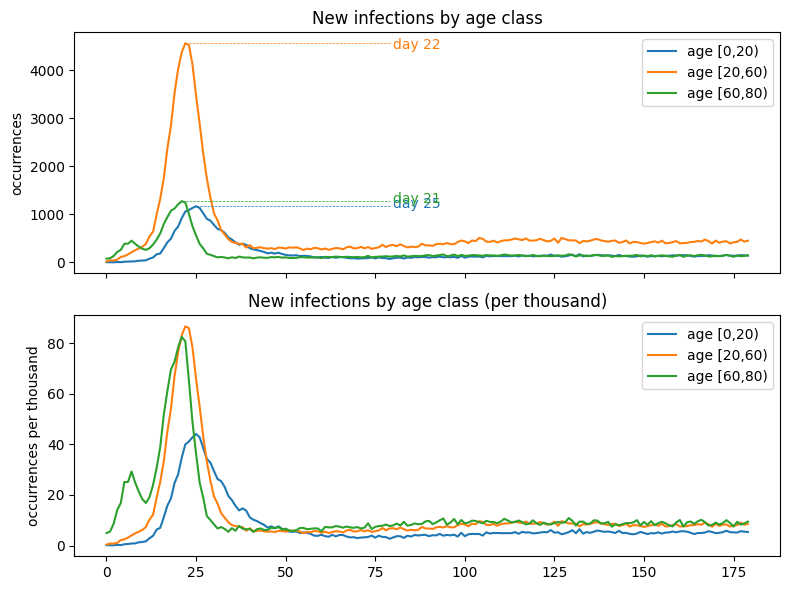

In [5]:
# Example 4: now run it

sim = BasicSimulator(rume)
with sim_messaging():
    out = sim.run()

# Extract population values from the RUME
data = rume.evaluate_params(rng=np.random.default_rng()).to_dict(simplify_names=True)
pop_00_19 = data["gpm:age_00-19::init::population"]
pop_20_59 = data["gpm:age_20-59::init::population"]
pop_60_79 = data["gpm:age_60-79::init::population"]

pop_thousands = (
    pop_00_19.sum() / 1000,
    pop_20_59.sum() / 1000,
    pop_60_79.sum() / 1000,
)

### GRAPHS ###

strata_label = ["age [0,20)", "age [20,60)", "age [60,80)"]

fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))

# On the first axis, plot the absolute values.
# We can use the Line2D objects returned from line_plt() to access the data.
lines = out.plot.line_plt(
    ax=ax1,
    geo=rume.scope.select.all().sum(),
    time=rume.time_frame.select.all().group("day").agg(),
    quantity=rume.ipm.select.events("*->I*").group().sum(),
    time_format="day",
)
ax1.set_title("New infections by age class")
ax1.set_ylabel("occurrences")
ax1.legend(strata_label)

# Mark day of peak infection by age class
for xy in lines:
    (_, y) = xy.get_data()
    dpi = int(np.argmax(y))  # day of peak infection

    # Calculate a good position for the label
    dpi_x_pos = 80  # an absolute x offset (to keep them horizontally aligned)
    dpi_y_pos = -0.025 * max(y)  # an offset from the peak's y position

    # Draw a line and a label for the peak
    color = xy.get_color()
    ax1.text(dpi_x_pos, y[dpi] + dpi_y_pos, f"day {dpi}", color=color)
    ax1.hlines(
        y=y[dpi],
        xmin=dpi,
        xmax=dpi_x_pos - 1,
        color=color,
        linewidth=0.5,
        linestyle="dashed",
    )

# On the second axis, plot the per-thousand-residents values.
for xy, pop in zip(lines, pop_thousands):
    (x, y) = xy.get_data()
    ax2.plot(x, y / pop)
ax2.set_title("New infections by age class (per thousand)")
ax2.set_ylabel("occurrences per thousand")
ax2.legend(strata_label)

fig.tight_layout()
plt.show()


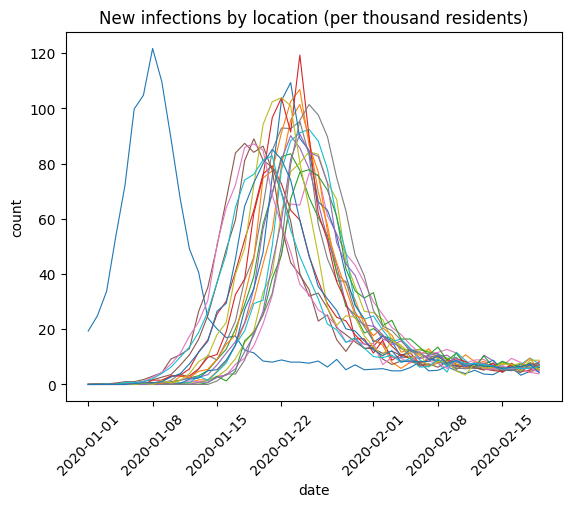

In [6]:
# Plot infections by location

pop_total_thousands = (pop_00_19 + pop_20_59 + pop_60_79) / 1000  # shape-(N,)


def per_thousand_residents(data_df):
    p = rume.scope.index_of(data_df["geo"].iloc[0])
    data_df["value"] = data_df["value"] / pop_total_thousands[p]
    return data_df


out.plot.line(
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.days(0, 50).group("day").agg(),
    quantity=rume.ipm.select.events("*->I*").group(strata=True, subscript=True).sum(),
    title="New infections by location (per thousand residents)",
    line_kwargs=[{"linewidth": 0.8}],
    transform=per_thousand_residents,
)

In [7]:
# Example 4...
print(rume.params_description())

gpm:age_00-19::ipm::beta (type: float, shape: TxN)
    infectivity

gpm:age_00-19::ipm::gamma (type: float, shape: TxN)
    progression from infected to recovered

gpm:age_00-19::ipm::xi (type: float, shape: TxN)
    progression from recovered to susceptible

gpm:age_20-59::ipm::beta (type: float, shape: TxN)
    infectivity

gpm:age_20-59::ipm::gamma (type: float, shape: TxN)
    progression from infected to recovered

gpm:age_20-59::ipm::xi (type: float, shape: TxN)
    progression from recovered to susceptible

gpm:age_60-79::ipm::beta (type: float, shape: TxN)
    infectivity

gpm:age_60-79::ipm::gamma (type: float, shape: TxN)
    progression from infected to recovered

gpm:age_60-79::ipm::xi (type: float, shape: TxN)
    progression from recovered to susceptible

meta::ipm::beta_12 (type: float, shape: TxN)

meta::ipm::beta_13 (type: float, shape: TxN)

meta::ipm::beta_21 (type: float, shape: TxN)

meta::ipm::beta_23 (type: float, shape: TxN)

meta::ipm::beta_31 (type: float, sha

In [8]:
print(rume.requirements_tree())

gpm:age_00-19::ipm::beta (float, TxN) <- gpm:age_00-19::ipm::beta
gpm:age_00-19::ipm::gamma (float, TxN) <- *::ipm::gamma
gpm:age_00-19::ipm::xi (float, TxN) <- *::ipm::xi
gpm:age_20-59::ipm::beta (float, TxN) <- gpm:age_20-59::ipm::beta
gpm:age_20-59::ipm::gamma (float, TxN) <- *::ipm::gamma
gpm:age_20-59::ipm::xi (float, TxN) <- *::ipm::xi
gpm:age_60-79::ipm::beta (float, TxN) <- gpm:age_60-79::ipm::beta
gpm:age_60-79::ipm::gamma (float, TxN) <- *::ipm::gamma
gpm:age_60-79::ipm::xi (float, TxN) <- *::ipm::xi
meta::ipm::beta_12 (float, TxN) <- meta::ipm::beta_12
meta::ipm::beta_13 (float, TxN) <- meta::ipm::beta_13
meta::ipm::beta_21 (float, TxN) <- meta::ipm::beta_21
meta::ipm::beta_23 (float, TxN) <- meta::ipm::beta_23
meta::ipm::beta_31 (float, TxN) <- meta::ipm::beta_31
meta::ipm::beta_32 (float, TxN) <- meta::ipm::beta_32
gpm:age_00-19::mm::population (int, N) <- gpm:age_00-19::*::population
  └╴gpm:age_00-19::mm::population_by_age_table (int, NxA) <- *::*::population_by_age_tabl

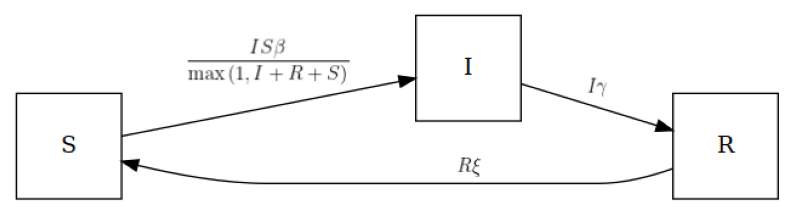

In [9]:
# Example 4...
rume.strata[0].ipm.diagram()

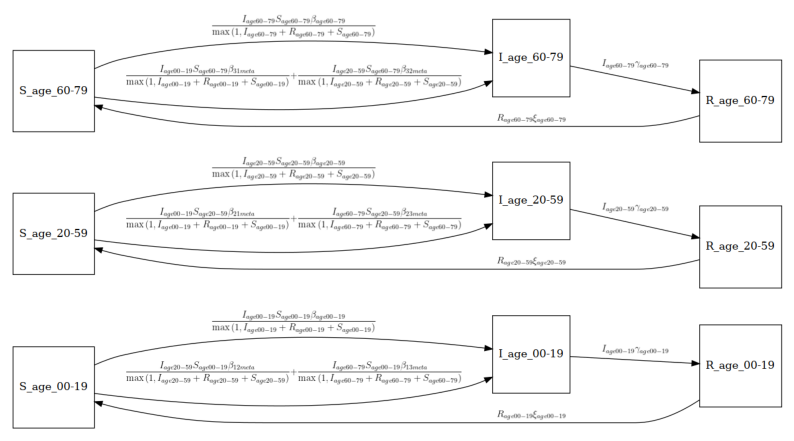

In [10]:
# Example 4...
rume.ipm.diagram()